In [1]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import patheffects as pe
import scipy as sc
import colour

The story of color spaces:
https://rgutzen.github.io/2020-11-05-color_spaces/

In [14]:
def noise_func(freqs, alpha=1, x0=0):
    power = 1. / (freqs-x0)**alpha
    power /= np.sum(power) * np.diff(freqs)[0]
    return power

In [3]:
l0, l1 = 390, 700 # nm
n = int((l1-l0+1)/1)
wavelength = np.linspace(l1, l0, n)
freqs = sc.constants.speed_of_light / wavelength

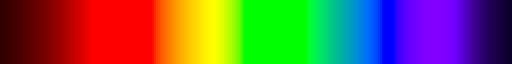

In [4]:
XYZ = colour.wavelength_to_XYZ(wavelength)
xyY = colour.XYZ_to_xyY(XYZ)
RGB = colour.XYZ_to_sRGB(XYZ)

# project values into valid RGB
RGB[RGB < 0] = 0
RGB[RGB > 1] = 1

freqs_map = np.linspace(0, 1, n)
colormapping = [(l, rgb) for l, rgb in zip(freqs_map, RGB)]
spectrum_cmap = mpl.colors.LinearSegmentedColormap.from_list('spectrum', colormapping)
spectrum_cmap

In [9]:
beta_values = [-2, -1, 0, 1, 2, 10]
noise_colors = ['violet','blue','white','pink','brown','black']
power = np.array([noise_func(freqs, beta) for beta in beta_values])
msd_power = colour.MultiSpectralDistribution(dict(zip(wavelength, power.T)),
                                             name='noise',
                                             labels=noise_colors).normalise()

/home/rgutzen/anaconda3/envs/py38/lib/python3.9/site-packages/colour/utilities/verbose.py:237: ColourUsageWarning: "colour.MultiSpectralDistribution" object has been renamed to "colour.MultiSpectralDistributions".
  warn(*args, **kwargs)


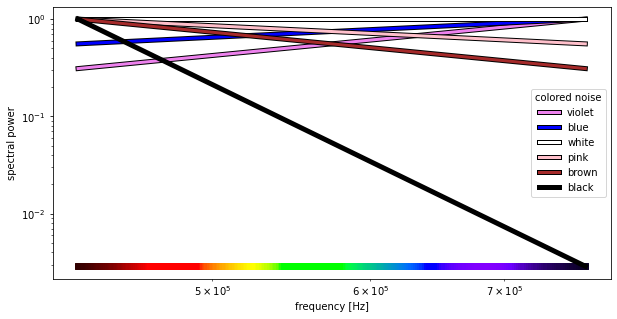

In [10]:
fig, ax = plt.subplots(figsize=(10,5))
ax.set_xlabel('frequency [Hz]')
ax.set_ylabel('spectral power')

for i, (beta, name) in enumerate(zip(beta_values, noise_colors)):
    ax.loglog(freqs, msd_power.values[:,i][::-1], label=name,
              lw=3, color=name,
              path_effects=[pe.Stroke(linewidth=5, foreground='k'), pe.Normal()])

ax.scatter(freqs, np.ones_like(freqs)*np.min(msd_power.values), 
           c=freqs_map, cmap=spectrum_cmap, marker='s')
plt.legend(title='colored noise')

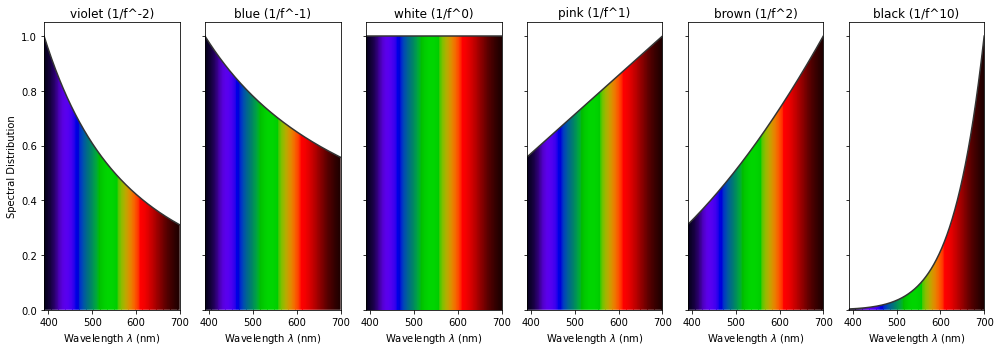

In [11]:
fig, ax = plt.subplots(ncols=len(msd_power.labels), sharex=True, sharey=True, figsize=(14,5))

for i, sds in enumerate(msd_power.to_sds()):
    colour.plotting.plot_single_sd(sds, 
                                   figure=fig, axes=ax[i], 
                                   standalone=False, 
                                   y_label='' if i else 'Spectral Distribution',
                                   title=f'{noise_colors[i]} (1/f^{beta_values[i]})')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


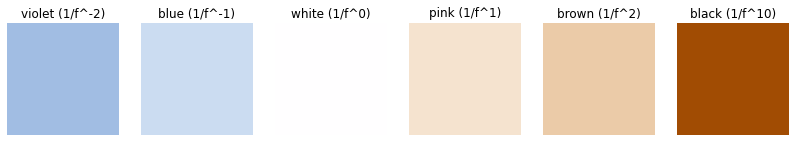

In [12]:
illuminant = np.array([0.31271,0.32902])
illuminant_sd = colour.sd_CIE_illuminant_D_series(illuminant)

XYZ = colour.wavelength_to_XYZ(msd_power.wavelengths)
xyY = colour.XYZ_to_xyY(XYZ, illuminant=illuminant)
# xyY = XYZ

fig, ax = plt.subplots(ncols=len(msd_power.labels), figsize=(14,5))

for i, sds in enumerate(msd_power.to_sds()):

    noise_color_XYZ = colour.sd_to_XYZ(sds, illuminant=illuminant_sd)/100
    noise_color_xyY = colour.XYZ_to_xyY(noise_color_XYZ, illuminant=illuminant)
#     print(noise_color_xyY)
#     noise_color_xyY[2] = 0.9
    noise_color_XYZ = colour.xyY_to_XYZ(noise_color_xyY)
    noise_color_RGB = colour.XYZ_to_sRGB(noise_color_XYZ, illuminant=illuminant)   

    ax[i].imshow(np.array([[noise_color_RGB]]))
    ax[i].set_axis_off()
    ax[i].set_title(f'{noise_colors[i]} (1/f^{beta_values[i]})')

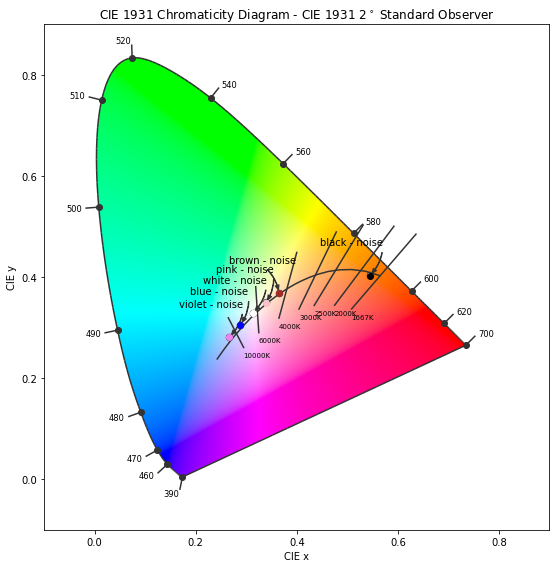

In [13]:
# fig, ax = colour.plotting.diagrams.plot_chromaticity_diagram(cmfs='CIE 1931 2 Degree Standard Observer')
fig, ax = plt.subplots(figsize=(8,8))
colour.plotting.diagrams.plot_sds_in_chromaticity_diagram(msd_power, method='CIE 1931',
                                                          axes=ax, standalone=False)
colour.plotting.temperature.plot_planckian_locus(method='CIE 1931', axes=ax, standalone=False)

for i, sds in enumerate(msd_power.to_sds()):
    noise_color_XYZ = colour.sd_to_XYZ(sds,  illuminant=illuminant_sd)/100
    x,y,Y = colour.XYZ_to_xyY(noise_color_XYZ, illuminant=illuminant)
    ax.scatter([x], [y], zorder=15, color=noise_colors[i])
